## 通过多项式回归来探索这些概念

以 $y=5+1.2 x-3.4 \frac{x^{2}}{2 !}+5.6 \frac{x^{3}}{3 !}+\epsilon \text { where } \epsilon \sim \mathcal{N}\left(0,0.1^{2}\right)$ 为例

噪声项 𝜖 服从均值为0且标准差为0.1的正态分布。在优化的过程中，我们通常希望避免非常大的梯度值或损失值。这就是我们将特征从 $x^{!}$ 调整为 $\frac{x^{i}}{i!}$ 的原因，这样可以避免很大的 𝑖 带来的特别大的指数值。我们将为训练集和测试集各生成100个样本

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [3]:
max_degree = 20  # 多项式的最大阶数
n_train, n_test = 100, 100  # 训练和测试数据集大小
true_w = np.zeros(max_degree)  # 分配大量的空间
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)  # `gamma(n)` = (n-1)!
# `labels`的维度: (`n_train` + `n_test`,)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

In [4]:
# NumPy ndarray转换为tensor
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.4171],
         [-0.6123]]),
 tensor([[ 1.0000e+00, -1.4171e+00,  1.0041e+00, -4.7429e-01,  1.6803e-01,
          -4.7623e-02,  1.1248e-02, -2.2770e-03,  4.0335e-04, -6.3509e-05,
           8.9999e-06, -1.1594e-06,  1.3692e-07, -1.4925e-08,  1.5107e-09,
          -1.4272e-10,  1.2641e-11, -1.0537e-12,  8.2958e-14, -6.1873e-15],
         [ 1.0000e+00, -6.1230e-01,  1.8745e-01, -3.8259e-02,  5.8565e-03,
          -7.1718e-04,  7.3188e-05, -6.4018e-06,  4.8998e-07, -3.3335e-08,
           2.0411e-09, -1.1361e-10,  5.7971e-12, -2.7304e-13,  1.1942e-14,
          -4.8745e-16,  1.8654e-17, -6.7188e-19,  2.2855e-20, -7.3652e-22]]),
 tensor([-2.8282,  3.4373]))

In [5]:
#评估给定数据集上模型的损失。
def evaluate_loss(net, data_iter, loss): 
    metric = d2l.Accumulator(2)  # 损失的总和, 样本数量
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [6]:
def train(train_features, test_features, train_labels, test_labels,num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式特征中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

## 三阶多项式函数拟合(正态)

weight: [[ 4.9904327  1.193257  -3.4006786  5.5698943]]


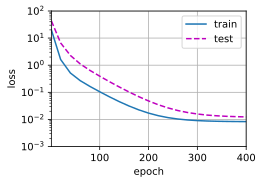

In [12]:
# 从多项式特征中选择前4个维度，即 1, x, x^2/2!, x^3/3!
train(poly_features[:n_train, :4], poly_features[n_train:, :4],labels[:n_train], labels[n_train:])

## 线性函数拟合(欠拟合)

weight: [[3.5215857 3.160755 ]]


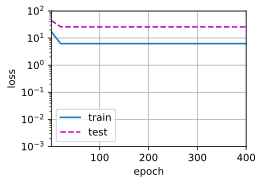

In [8]:
# 从多项式特征中选择前2个维度，即 1, x
train(poly_features[:n_train, :2], poly_features[n_train:, :2],labels[:n_train], labels[n_train:])

## 高阶多项式函数拟合(过拟合)

weight: [[ 4.9815445   1.261423   -3.339948    5.1358604  -0.159485    1.4984013
   0.02496916 -0.03533871  0.16215059  0.15507698  0.19745195 -0.08629154
   0.0614872   0.08828509  0.10215756 -0.03117053 -0.07761534  0.16323006
   0.06731933  0.22295693]]


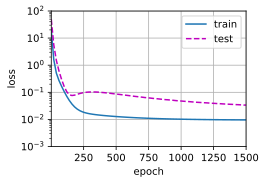

In [9]:
# 从多项式特征中选取所有维度
train(poly_features[:n_train, :], poly_features[n_train:, :],labels[:n_train], labels[n_train:], num_epochs=1500)